In [43]:
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import ipywidgets as widgets
from ipywidgets import interact
from scipy.ndimage import rotate
from sklearn.model_selection import train_test_split
import keras
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
import cv2
import pandas as pd
from collections import Counter
from IPython.display import display



In [2]:
from kmeans import KMeans

In [3]:
# Check if GPU is available and working
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

# Simple test
model = tf.keras.Sequential([tf.keras.layers.Dense(1)])
print("TensorFlow/Keras working normally!")

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.18.0
TensorFlow/Keras working normally!


# Introduction

The BraTS (Brain Tumour Segmentation) dataset consists of multi-modal MRI images of brain tumours, specifically gliomas, a subtype which represents about 80% of all malignant brain tumours, and the corresponding segmentation masks. The dataset is updated yearly in the context of the MICCAI (Medical Image Computing and Computer-Assisted Intervention) conference. The latest data available is from BraTS2023, but we chose to work with BraTS2020. This was done because the size of the 2020 dataset, at 369 patients, is already enough to make the computations needed very lenghty on the systems at our disposal. BraTS2021 and BraTS2022 comprise data from more than 2000 patients while BraTS2023 goes up to 4500 patients, which were computationally unfeasible with the computers at hand.

The BraTS2020 dataset is made up of routine clinically-acquired pre-operative multimodal MRI of glioblastoma and lower-grade glioma with accompanying ground truth labels by board-certified neuroradiologists. The scans have been taken at 19 different insitutions and come in the NIfTI format (.nii.gz), a standard format for MRI images. They are multi-modal in the sense that, for each of the 369 patients, 4 different MRI configurations have been used:

a) native (T1) and b) post-contrast T1-weighted (T1Gd)

c) T2-weighted (T2), and d) T2 Fluid Attenuated Inversion Recovery (T2-FLAIR)

T1 and T2 refer to longitudinal and transversal relaxing time respectively and are the two main focus of MRI imaging. Through the differences in the longitudinal and transversal relaxing time one can distinguish a certain type of biological tissue from another. In T1 scans, white matter appears brilliant, grey matter appears grey and liquids and lesions appear darker. T1Gd is when a T1 scan is used together with a Gadolinium-based contrast which, being absorbed by those tissues with a compromised blood-brain barrier, allows to easily distinguish the active part of the tumour (called enhancing tumour). In T2 scans, on the countrary, liquid and lesions are brilliant and white matter is dark. T2-FLAIR is a technique which allows to darken the cerebrospinal fluid (CSF) making it easier to distinguish the edema due to the tumour.

Data from a mix of these modalities allows for a correct segmentation of the tumour tissue and is fundamental for the practical work of neurosurgeons and neuroradiologists, which need to understand the geometry and composition of the tumour. This kind of segmentation task is made more difficult by the heterogeneity of gliomas and the different tissues making up a tumour. Three different patological tissues are considered here: A) Enhancing Tumour Core, which represents the active part of the disease and has label 4, B) Necrotic and Non-Enhancing Tumour Core, which are inactive parts of the tumour and are labelled 1, and C) Peritumoral Edema, which is fluid that accumulates around the tumour and is labelled with 2. The fourth and last label, 0, is used for everything else (the rest of the brain with all its structures and CSF).

# Loading the Scans with Nibabel

To work with NIfTI (Neuroimaging Informatics Technology Initiative) data one can use the Nibabel library, which has been created to easily access and manipulate neurological data in various medical formats. We use it to extract the scans voxel values into a NumPy array, allowing us to work with more familiar objects afterwards.

Each set of scans has 155 slices with 240x240 pixels per slice (so we have 240x240x155 voxels per modality). We have 4 modalities per patient and 369 patients in total. In the cell below we demonstrate how to load the modalities from patient 355. We also rescale the images as this format can have voxel intensity values which vary from 0 to a few thousands and we want to keep all modalities in the same scale so that the model can confront slices without any bias due only to the differing scales.

In [5]:
# Directory di Chiara
#TRAIN_DATASET_PATH = "/Users/chiaracangelosi/Documents/1-Uni/DataScience/Dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

#Directory di Gianluca
#TRAIN_DATASET_PATH= "C:/Users/g2not/Desktop/Università/Data Mining and Machine Learning/Progetto/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

#Directory Kaggle
TRAIN_DATASET_PATH= "/kaggle/input/brats2020/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

# Carica il file .nii come array NumPy sfruttando nibabel
#test_image_flair_ = nib.load(TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_flair.nii")
#print(test_image_flair_.header)

test_image_flair = nib.load(TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_flair.nii").get_fdata()

# Informazioni sull'immagine
print("FLAIR Shape: ", test_image_flair.shape)
print("FLAIR Dtype: ", test_image_flair.dtype)
print("FLAIR Min: ", test_image_flair.min())
print("FLAIR Max: ", test_image_flair.max())

# Rescaling voxel-wise a [0, 1]
test_image_flair = (test_image_flair - np.min(test_image_flair)) / (np.max(test_image_flair) - np.min(test_image_flair))

# Verifica
print("Rescaled min:", test_image_flair.min())
print("Rescaled max:", test_image_flair.max(), "\n")

#Carichiamo e riscaliamo alla stessa maniera anche le altre modalità
test_image_t1 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
print("T1 Shape: ", test_image_t1.shape)
print("T1 Min: ", test_image_t1.min())
print("T1 Max: ", test_image_t1.max(), "\n")

test_image_t1 = (test_image_t1 - np.min(test_image_t1)) / (np.max(test_image_t1) - np.min(test_image_t1))

test_image_t1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
print("T1ce Shape: ", test_image_t1ce.shape)
print("T1ce Min: ", test_image_t1ce.min())
print("T1ce Max: ", test_image_t1ce.max(), "\n")

test_image_t1ce = (test_image_t1ce - np.min(test_image_t1ce)) / (np.max(test_image_t1ce) - np.min(test_image_t1ce))

test_image_t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
print("T2 Shape: ", test_image_t2.shape)
print("T2 Min: ", test_image_t2.min())
print("T2 Max: ", test_image_t2.max(), "\n")

test_image_t2 = (test_image_t2 - np.min(test_image_t2)) / (np.max(test_image_t2) - np.min(test_image_t2))

# La maschera di segmentazione non va riscalata, in quanto i valori che assume sono 0, 1, 2 e 4 a seconda del tipo di tessuto
# 0 = background, 1 = edema, 2 = non-enhancing tumour, 4 = enhancing tumour
test_image_seg = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()
print("Mask Shape: ", test_image_seg.shape)
print("Mask Min: ", test_image_seg.min())
print("Mask Max: ", test_image_seg.max())

FLAIR Shape:  (240, 240, 155)
FLAIR Dtype:  float64
FLAIR Min:  0.0
FLAIR Max:  1854.603271484375
Rescaled min: 0.0
Rescaled max: 1.0 

T1 Shape:  (240, 240, 155)
T1 Min:  0.0
T1 Max:  1717.368408203125 

T1ce Shape:  (240, 240, 155)
T1ce Min:  0.0
T1ce Max:  8309.0 

T2 Shape:  (240, 240, 155)
T2 Min:  0.0
T2 Max:  5822.11474609375 

Mask Shape:  (240, 240, 155)
Mask Min:  0.0
Mask Max:  4.0


# Data Visualization

In the following cell a dynamic visualization is built so that one can check how the different scans and the corresponding mask evolves slice by slice. In the mask, black represents healthy tissue (therefore it shows as the background for the tumoral tissue), green is the Necrotic and Non-Enhancing tissue, yellow is the Edema while light blue is used for the Enhancing Tumour Core. The visualization is again using the data we already loaded relative to patient 355.

In [6]:
# === Colori per la maschera ===
labels = [0, 1, 2, 4]
colors = ['black', 'green', 'yellow', 'lightblue']
class_names = ['Background (0)', 'NCR & NET (1)', 'Edema (2)', 'Enhancing Tumor (4)']
cmap_mask = ListedColormap(colors)
norm = BoundaryNorm([0, 0.5, 1.5, 3, 5], cmap_mask.N)

# === Visualizzazione dinamica ===
def show_slice(slice_idx):
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))

    # MRI modalities
    titles = ['T1', 'T1ce', 'T2', 'FLAIR']
    volumes = [test_image_t1, test_image_t1ce, test_image_t2, test_image_flair]

    for i in range(4):
        axs[i // 3, i % 3].imshow(volumes[i][:, :, slice_idx], cmap='gray')
        axs[i // 3, i % 3].set_title(titles[i])
        axs[i // 3, i % 3].axis('off')

    # Mask
    axs[1, 1].imshow(test_image_seg[:, :, slice_idx], cmap=cmap_mask, norm=norm)
    axs[1, 1].set_title('Mask')
    axs[1, 1].axis('off')

    # Legend
    axs[1, 2].axis('off')
    patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(len(labels))]
    axs[1, 2].legend(handles=patches, loc='center')

    plt.tight_layout()
    plt.show()

# === Interfaccia interattiva ===
interact(
    show_slice,
    slice_idx=widgets.IntSlider(
        value=95,
        min=0,
        max=test_image_t1.shape[2] - 1,
        step=1,
        description='Slice:',
        continuous_update=True
    )
)

interactive(children=(IntSlider(value=95, description='Slice:', max=154), Output()), _dom_classes=('widget-int…

<function __main__.show_slice(slice_idx)>

The transverse view is not the only useful visualization of MRI scans, frontal and sagittal angles are other useful options. Below is an example of the same modality, T1, shown by slicing over the other dimensions.

In [7]:
# Visualizzazione delle viste trasversa, frontale e sagittale
def show_views(slice_idx):
    fig = plt.figure(figsize=(12, 5))

    H, W, D = test_image_t1ce.shape  # 240, 240, 155
    
    # Transverse View
    z_idx = min(slice_idx, D - 1) # Assicura di non eccedere l'indice
    ax1 = fig.add_subplot(1, 3, 1)
    img1 = test_image_t1ce[:, :, z_idx]
    ax1.imshow(img1, cmap='gray')
    ax1.set_title(f'T1 - Transverse (Z={z_idx})')
    ax1.axis('off')

    # Frontal View 
    y_idx = min(slice_idx, W - 1)
    ax2 = fig.add_subplot(1, 3, 2)
    img2 = rotate(test_image_t1ce[:, y_idx, :], 90, reshape=True)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(f'T1 - Frontal (Y={y_idx})')
    ax2.axis('off')

    # Sagittal View
    x_idx = min(slice_idx, H - 1)
    ax3 = fig.add_subplot(1, 3, 3)
    img3 = rotate(test_image_t1ce[x_idx, :, :], 90, reshape=True)
    ax3.imshow(img3, cmap='gray')
    ax3.set_title(f'T1 - Sagittal (X={x_idx})')
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

# Slider interattivo
max_index = max(test_image_t1ce.shape)  # 240
interact(
    show_views,
    slice_idx=widgets.IntSlider(
        value=95,
        min=0,
        max=max_index - 1,
        step=1,
        description='Slice:',
        continuous_update=True
    )
)


interactive(children=(IntSlider(value=95, description='Slice:', max=239), Output()), _dom_classes=('widget-int…

<function __main__.show_views(slice_idx)>

In [8]:
# === Mappa colori e normalizzazione (adatta a BraTS ad esempio)
labels = [0, 1, 2, 4]
colors = ['black', 'green', 'yellow', 'lightblue']
class_names = ['Background (0)', 'NCR/NET (1)', 'Edema (2)', 'Enhancing Tumor (4)']
cmap = ListedColormap(colors)
norm = BoundaryNorm([0, 0.5, 1.5, 3, 5], len(colors))

# === Funzione dinamica
def show_segmented_slice(slice_idx):
    # Isola ogni classe come maschera separata (usando NaN per trasparenza)
    seg_0 = test_image_seg.copy()
    seg_0[seg_0 != 0] = np.nan
    
    seg_1 = test_image_seg.copy()
    seg_1[seg_1 != 1] = np.nan
    
    seg_2 = test_image_seg.copy()
    seg_2[seg_2 != 2] = np.nan
    
    seg_4 = test_image_seg.copy()
    seg_4[seg_4 != 4] = np.nan

    # Legenda personalizzata
    legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

    # Plot
    fig, ax = plt.subplots(1, 5, figsize=(20, 5))

    ax[0].imshow(test_image_seg[:, :, slice_idx], cmap=cmap, norm=norm)
    ax[0].set_title('Original Segmentation')
    ax[0].legend(handles=legend, loc='lower left')
    ax[0].axis('off')

    ax[1].imshow(seg_0[:, :, slice_idx], cmap=cmap, norm=norm)
    ax[1].set_title('Class 0 (Background)')
    ax[1].axis('off')

    ax[2].imshow(seg_1[:, :, slice_idx], cmap=cmap, norm=norm)
    ax[2].set_title('Class 1 (NCR/NET)')
    ax[2].axis('off')

    ax[3].imshow(seg_2[:, :, slice_idx], cmap=cmap, norm=norm)
    ax[3].set_title('Class 2 (Edema)')
    ax[3].axis('off')

    ax[4].imshow(seg_4[:, :, slice_idx], cmap=cmap, norm=norm)
    ax[4].set_title('Class 4 (Enhancing Tumor)')
    ax[4].axis('off')

    plt.tight_layout()
    plt.show()

# === Slider interattivo
interact(
    show_segmented_slice,
    slice_idx=widgets.IntSlider(
        value=95,
        min=0,
        max=test_image_seg.shape[2] - 1,
        step=1,
        description='Slice:',
        continuous_update=True
    )
)

interactive(children=(IntSlider(value=95, description='Slice:', max=154), Output()), _dom_classes=('widget-int…

<function __main__.show_segmented_slice(slice_idx)>

# Metrics K-Means and NMF

In [10]:
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import directed_hausdorff

def compute_metrics(true_labels, pred_labels, n_classes=4):
    """
    Compute Dice, Sensitivity, Precision, and Hausdorff Distance for each class.
    """
    # Remap ground truth: 4 -> 3
    true_processed = true_labels.copy()
    true_processed[true_processed == 4] = 3
    
    # Flatten arrays
    true_flat = true_processed.flatten()
    pred_flat = pred_labels.flatten()
    
    # Use Hungarian algorithm to map clusters to classes
    conf_matrix = confusion_matrix(true_flat, pred_flat, labels=range(n_classes))
    row_ind, col_ind = linear_sum_assignment(-conf_matrix)
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    mapped_pred = np.vectorize(mapping.get)(pred_flat).reshape(pred_labels.shape)
    
    metrics_dict = {}
    for class_id in range(n_classes):
        true_binary = (true_processed == class_id)
        pred_binary = (mapped_pred == class_id)
        
        # Dice Coefficient
        intersection = np.logical_and(true_binary, pred_binary).sum()
        dice = (2. * intersection) / (true_binary.sum() + pred_binary.sum() + 1e-6)
        
        # Sensitivity (Recall)
        sensitivity = intersection / (true_binary.sum() + 1e-6)
        
        # Precision
        precision = intersection / (pred_binary.sum() + 1e-6)
        
        # Hausdorff Distance
        hd = np.nan
        if np.any(true_binary) and np.any(pred_binary):
            coords_true = np.argwhere(true_binary)
            coords_pred = np.argwhere(pred_binary)
            hd = max(directed_hausdorff(coords_true, coords_pred)[0],
                     directed_hausdorff(coords_pred, coords_true)[0])
        
        metrics_dict[class_id] = {
            'Dice': dice,
            'Sensitivity': sensitivity,
            'Precision': precision,
            'Hausdorff Distance': hd
        }
    
    return metrics_dict, mapped_pred

In [11]:
def plot_segmentation_comparison(true_slice, pred_slice, metrics_dict, method_name, slice_idx):
    """
    Plot the segmentation results and metrics comparison.
    
    Parameters:
    true_slice: Ground truth segmentation slice
    pred_slice: Predicted segmentation slice (after Hungarian mapping)
    metrics_dict: Dictionary containing metrics for each class
    method_name: Name of the segmentation method
    slice_idx: Index of the slice being visualized
    """
    # Define colors and class names (note: we've remapped class 4 to class 3)
    labels = [0, 1, 2, 3]
    colors = ['black', 'green', 'yellow', 'lightblue']
    class_names = ['Background (0)', 'NCR & NET (1)', 'Edema (2)', 'Enhancing Tumor (3)']
    cmap_mask = ListedColormap(colors)
    norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap_mask.N)
    
    # Create figure with subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot original segmentation
    axs[0].imshow(pred_slice, cmap=cmap_mask, norm=norm)
    axs[0].set_title(f'{method_name} Segmentation - Slice {slice_idx}')
    axs[0].axis('off')
    
    # Plot ground truth
    # Remap ground truth: 4 -> 3 for consistent visualization
    true_remapped = true_slice.copy()
    true_remapped[true_remapped == 4] = 3
    axs[1].imshow(true_remapped, cmap=cmap_mask, norm=norm)
    axs[1].set_title('Ground Truth (BraTS Segmentation)')
    axs[1].axis('off')
    
    # Create metrics table
    metrics_text = f"{method_name} Metrics:\n\n"
    class_names = ['Background', 'Necrotic/Core', 'Edema', 'Enhancing']
    for class_id, metrics in metrics_dict.items():
        metrics_text += f"{class_names[class_id]}:\n"
        metrics_text += f"  Dice = {metrics['Dice']:.4f}\n"
        metrics_text += f"  Sensitivity = {metrics['Sensitivity']:.4f}\n"
        metrics_text += f"  Precision = {metrics['Precision']:.4f}\n"
        metrics_text += f"  Hausdorff = {metrics['Hausdorff Distance']:.4f}\n\n"
    
    # Display metrics
    axs[2].text(0.1, 0.5, metrics_text, fontsize=10, verticalalignment='center')
    axs[2].set_title('Evaluation Metrics')
    axs[2].axis('off')
    
    # Add legend
    patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(len(labels))]
    axs[1].legend(handles=patches, loc='lower left', bbox_to_anchor=(1.05, 0))
    
    plt.tight_layout()
    plt.show()

In [ ]:
"""def compute_unet_metrics(true_labels, pred_probabilities, threshold=0.5):
    
    Compute metrics for U-Net output.
    pred_probabilities: Probability maps [H, W, 4] or [H, W, D, 4]
    
    # Remap ground truth: 4 -> 3 (if needed)
    true_processed = true_labels.copy()
    true_processed[true_processed == 4] = 3
    
    # Get predicted labels by taking argmax of probability maps
    pred_labels = np.argmax(pred_probabilities, axis=-1)
    
    # Flatten arrays
    true_flat = true_processed.flatten()
    pred_flat = pred_labels.flatten()
    
    # Compute metrics without Hungarian mapping
    metrics_dict = {}
    for class_id in range(4):  # 4 classes after remapping
        true_binary = (true_processed == class_id)
        pred_binary = (pred_labels == class_id)
        
        # Dice Coefficient
        intersection = np.logical_and(true_binary, pred_binary).sum()
        dice = (2. * intersection) / (true_binary.sum() + pred_binary.sum() + 1e-6)
        
        # Sensitivity (Recall)
        sensitivity = intersection / (true_binary.sum() + 1e-6)
        
        # Precision
        precision = intersection / (pred_binary.sum() + 1e-6)
        
        # Hausdorff Distance
        hd = np.nan
        if np.any(true_binary) and np.any(pred_binary):
            coords_true = np.argwhere(true_binary)
            coords_pred = np.argwhere(pred_binary)
            hd = max(directed_hausdorff(coords_true, coords_pred)[0],
                     directed_hausdorff(coords_pred, coords_true)[0])
        
        metrics_dict[class_id] = {
            'Dice': dice,
            'Sensitivity': sensitivity,
            'Precision': precision,
            'Hausdorff Distance': hd
        }
    
    return metrics_dict, pred_labels"""

In [12]:
def print_metrics(metrics_dict, method_name):
    print(f"\n{method_name} Metrics:")
    class_names = ['Background', 'Necrotic/Core', 'Edema', 'Enhancing']
    for class_id, metrics in metrics_dict.items():
        print(f"{class_names[class_id]}:")
        print(f"  Dice = {metrics['Dice']:.4f}")
        print(f"  Sensitivity = {metrics['Sensitivity']:.4f}")
        print(f"  Precision = {metrics['Precision']:.4f}")
        print(f"  Hausdorff Distance = {metrics['Hausdorff Distance']:.4f}\n")

# K-Means

Image segmentation is a kind of task in which Machine Learning has shown to be vastly superior to older algorithmical methods. The task at hand, due to the heterogeneous nature of the segmentation of MRI images, is yet another case in which modern deep learning techniques outperform other types of techniques. We still decided to try two non-ML segmentation methods, K-Means and Non-Negative Matrix Factorization (NMF), to obtain a baseline level performance for comparison with the U-Net architecture that will be applied later on in the project.

Our application of these methods is barebones. While researchers trying to apply these methodologies would often use them in combination with a series of filters, edge detectors, thresholding methods that could increase the performances (as well as requiring a lot of manual labor and heuristics), here we limit ourselves to applying this techniques directly.

In very simple segmentation tasks, using non-ML methods can still sometimes be useful, especially when there isn't enough data to train complex models on and/or when the segmentation is so simple that one can prefer techniques which are computationally much cheaper. In the context of medical imaging however, given the high precision needed to obtain actually usable software, classical techniques don't really find any application if not in pre- or post-processing of other algorithms input/output.

To apply the K-Means algorithm, we extract a certain slice (corresponding to a mask showing every kind of tumoral tissue) from a patient data for every modality. For example, the slice 95 from patient 355 for T1, T1ce, T2 and T2-FLAIR. We then unite these 4 slices into a single 240x240x4 array which is reshaped into a 57600x4 array. This is necessary because K-Means works on a 2D array representing the observations and corresponding features. We then visualize the clusters the algorithm found.

The result strongly depends on the specific initialization. If the initial centroids all fall into the background section, than K-Means will cluster the whole image as a single cluster. If the initialization is more varied, we obtain more varied results. Because of the non-semantic nature of K-Means, some of the divisions it finds, like the one between CSF and healthy brain, while anatomically correct, are not of interest for the task at hand. Relative to the tumoral tissue, while it doesn't do a perfect job and while it can't always distinguish ET from ED, it is sometimes able to segment the different parts of the disease with a moderate level of accuracy.

In [13]:
#Parametri
slice_idx = 95
k = 4  # Numero di cluster per K-Means
 
#Slice delle differenti modalità
flair_slice = test_image_flair[:, :, slice_idx]
t1_slice = test_image_t1[:, :, slice_idx]
t1ce_slice = test_image_t1ce[:, :, slice_idx]
t2_slice = test_image_t2[:, :, slice_idx]
mask_slice = test_image_seg[:, :, slice_idx]
 
# Le slice vengono congiunte attraverso il metodo stack, che unisce più array lungo una
# nuova dimensione. Con un reshape, ogni pixel viene rappresentato da un vettore di 4 valori (uno per ogni modalità)

X = np.stack([flair_slice, t1_slice, t1ce_slice, t2_slice], axis=-1) #240x240x4
print("Shape of X:", X.shape)
X_reshaped = X.reshape((-1, 4)).astype(np.float32) #240x240=57600 -> 57600x4, KMeans lavora su un array 2D
print("Shape of X_reshaped:", X_reshaped.shape)

# Applica K-Means
km = KMeans(n_clus=k)
km.fit(X_reshaped)
clusters = km.getClusters()
 
# Ritorniamo alla dimensione 240x240
segmented_image = clusters.reshape(flair_slice.shape) 

Shape of X: (240, 240, 4)
Shape of X_reshaped: (57600, 4)


As remarked above, K-Means is non-semantic. It is an unsupervised technique. This means that the clusters found need to be manually associated, in an heuristic manner, to ground truth labels. To make this association we take advantage of the hungarian algorithm. This then enables us to calculate the specificity, precision and Dice Coefficient. We also define a function allowing us to calculate the symmetric Hausdorff distance. These metrics work in tandem, in the sense that even having a good overlap between the ground truth label and the prediction doesn't guarantee that a section of the ground truth, small in area, may lie "far" from the predicted mask. The hausdorff distance, here measured in pixels, allows us to check the "maximum minimum" distance between the two masks, informing us in the case that a section of the mask in not being correctly classified by the model even if the total overlap is high.

In [14]:
# Extract the same slice from ground truth that was used for K-Means
true_slice = test_image_seg[:, :, slice_idx]

# Compute metrics for this specific slice
kmeans_metrics, kmeans_mapped = compute_metrics(true_slice, segmented_image)

# Print the results
print_metrics(kmeans_metrics, "K-Means")


K-Means Metrics:
Background:
  Dice = 0.8857
  Sensitivity = 0.7948
  Precision = 1.0000
  Hausdorff Distance = 58.5235

Necrotic/Core:
  Dice = 0.5021
  Sensitivity = 1.0000
  Precision = 0.3352
  Hausdorff Distance = 30.5287

Edema:
  Dice = 0.0790
  Sensitivity = 0.3262
  Precision = 0.0449
  Hausdorff Distance = 67.6240

Enhancing:
  Dice = 0.0000
  Sensitivity = 0.0000
  Precision = 0.0000
  Hausdorff Distance = 73.2462



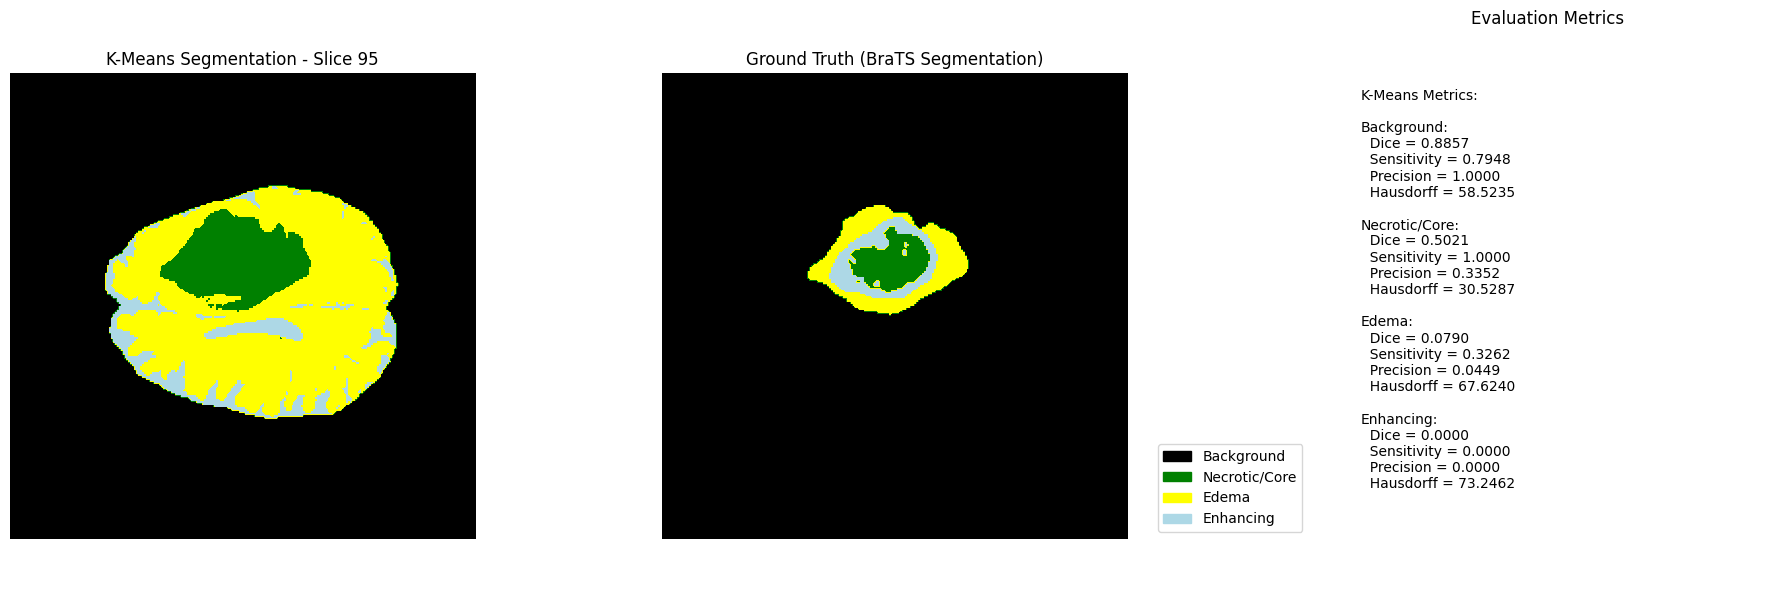

In [15]:
plot_segmentation_comparison(true_slice, kmeans_mapped, kmeans_metrics, "K-Means", slice_idx)

# Non-Negative Matrix Factorization

In this section we repeat a process that is completely analogous to the previous K-Means section. We fit a "classical" model, namely Non-Negative Matrix Factorization, on an example slice to obtain a "classical" baseline perfomance level. The same metrics are used. We can see that NMF performs worse than K-Means, with much more confused clusters and consequently mostly worse metrics (with the exception of the background).


NMF Metrics:
Background:
  Dice = 0.9272
  Sensitivity = 0.8656
  Precision = 0.9982
  Hausdorff Distance = 9.2195

Necrotic/Core:
  Dice = 0.0043
  Sensitivity = 0.0118
  Precision = 0.0027
  Hausdorff Distance = 77.7817

Edema:
  Dice = 0.6367
  Sensitivity = 0.8814
  Precision = 0.4983
  Hausdorff Distance = 58.1378

Enhancing:
  Dice = 0.2185
  Sensitivity = 0.6751
  Precision = 0.1303
  Hausdorff Distance = 73.7835



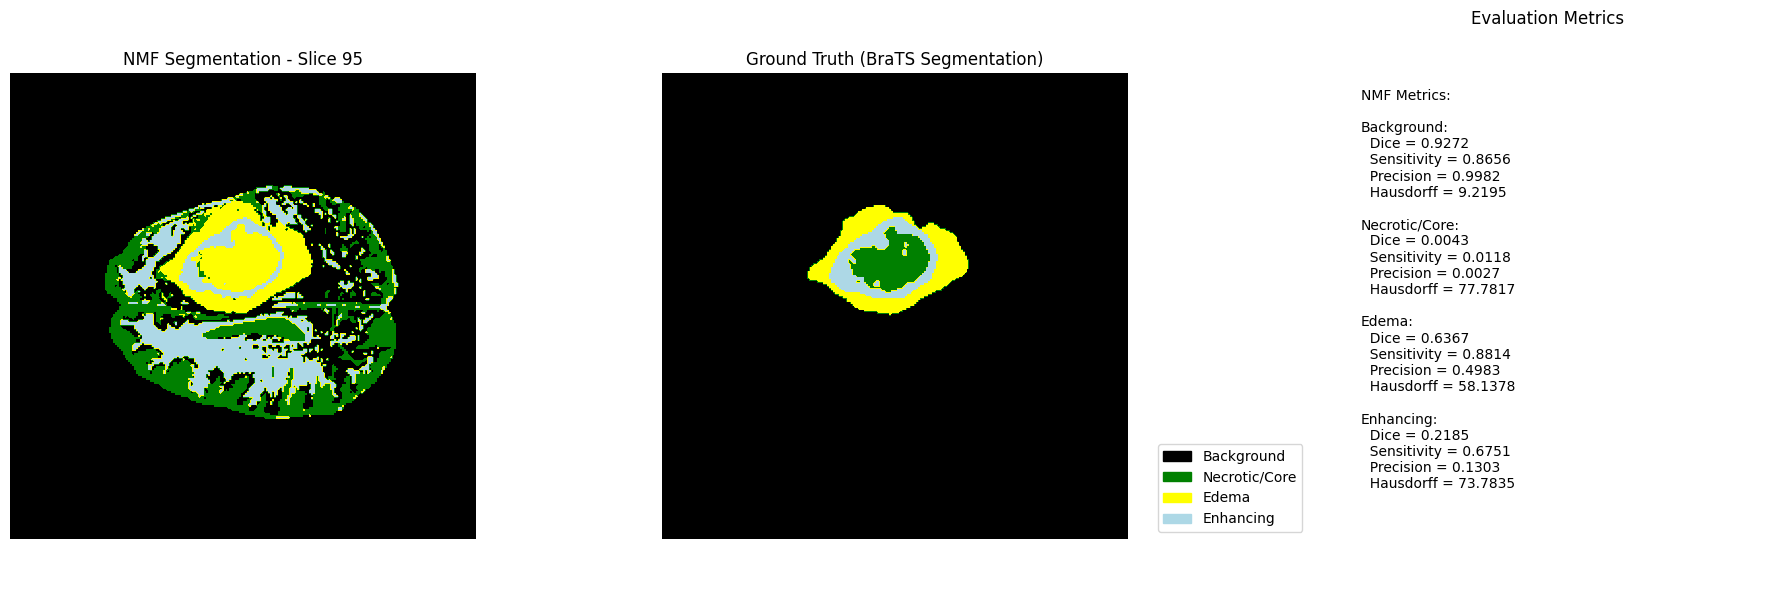

In [16]:
from sklearn.decomposition import NMF

# Parameters (use the same as K-Means)
slice_idx = 95
n_components = 4

# Prepare the data (same as for K-Means)
flair_slice = test_image_flair[:, :, slice_idx]
t1_slice = test_image_t1[:, :, slice_idx]
t1ce_slice = test_image_t1ce[:, :, slice_idx]
t2_slice = test_image_t2[:, :, slice_idx]
mask_slice = test_image_seg[:, :, slice_idx]

X = np.stack([flair_slice, t1_slice, t1ce_slice, t2_slice], axis=-1)
X_reshaped = X.reshape((-1, 4)).astype(np.float32)

# Apply NMF
model = NMF(n_components=n_components, init='nndsvda', random_state=42)
W = model.fit_transform(X_reshaped)
    
# Assign each pixel to the component with the highest value
nmf_segmented_flat = np.argmax(W, axis=1)
nmf_segmented_image = nmf_segmented_flat.reshape(flair_slice.shape)

# Compute metrics
nmf_metrics, nmf_mapped = compute_metrics(mask_slice, nmf_segmented_image)

# Print metrics
print_metrics(nmf_metrics, "NMF")

# Plot the results
plot_segmentation_comparison(mask_slice, nmf_mapped, nmf_metrics, "NMF", slice_idx)

# Data Splitting and Pre-Processing

In the previous section we only really loaded data from patient 355. Now we need to prepare all the data at our disposal for the training and testing phases of the ML pipeline. The first thing we do is subdivide the 369 patients into training set (250 patients, 68% of the total), validation set (74 patients, 20%) and test set (45 patients, 12%).

In [17]:
# Lista degli ID (ultime parti dei path delle directory)
train_and_test_ids = [f.name for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# 80% train+test, 20% validation
train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2, random_state=42)

# Split train+test in 85% train (68% del totale), 15% test (12% del totale)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15, random_state=42)

print(f"Train length: {len(train_ids)} pazienti")
print(f"Validation length: {len(val_ids)} pazienti")
print(f"Test length: {len(test_ids)} pazienti")

Train length: 250 pazienti
Validation length: 74 pazienti
Test length: 45 pazienti


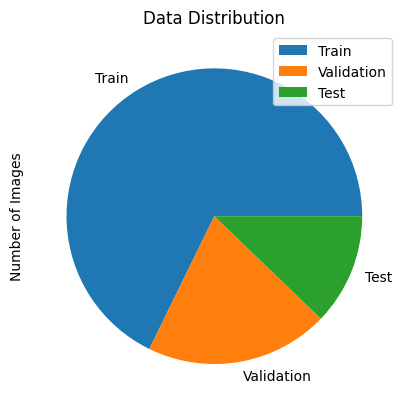

In [18]:
plt.pie(
        [len(train_ids), len(val_ids), len(test_ids)],
        labels=['Train', 'Validation', 'Test'],
       )

plt.legend(loc='upper right')

plt.ylabel('Number of Images')
plt.title('Data Distribution')

plt.show()

The data as is needs to be preprocessed before being used in the training of the model. To do this, we define a DataGenerator from Keras to achieve all of the steps in an organized way.

In the first cell, we define the number of slices to utilize and the starting index of these interval. We decided to use about 100 slices per modality. This comes down to the fact that many of the slices do not contain sections of the tumour and therefore do not contain information useful for the training of our segmentation model. This allows us , given that we train our model in trasverse direction, to reduce the computations per modalities by about a third (100/155 = 64,5%).

Another parameter defined in the first cell is the image size. Instead of using the original images, whose dimension along the trasverse direction is 240x240, we resize them down to 128x128. This allows to obtain a resolution in powers of 2, which makes applying max-pooling layers straighforward. Also, this strongly reduces computational time.

In [19]:
SEGMENT_CLASSES = {
    0 : 'Background',
    1 : 'Necrotic/Non-Enhancing', 
    2 : 'Edema',
    3 : 'Enhancing'
}

# Select Slices and Image Size
VOLUME_SLICES = 100
VOLUME_START_AT = 22 
IMG_SIZE = 128

In [20]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size # Numero di pazienti per batch
        self.list_IDs = list_IDs
        self.n_channels = n_channels # Numero di modalità (FLAIR, T1ce)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generates one batch of data'
        # Generates indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generates data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i) # i is the index of the patient

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            t1ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES): # Loading the resized T1ce, FLAIR and standard segmentation
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        y[y==4] = 3; # Label 4 to 3
        mask = tf.one_hot(y, 4); # One-hot encoding to avoid any hierarchy
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE)); #Resizing bilinearly (soft masks)
        return X/np.max(X), Y #Normalize the full volume of the batch (Batchsize*VOLUME_SLICES)
                              #Example: batch_size=2, VOLUME_SLICES=100 -> 200 slices normalized together
                              
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)


print("Numero di batch nel training set:", len(training_generator))
print("Numero di batch nel validation set:", len(valid_generator))
print("Numero di batch nel test set:", len(test_generator))

Numero di batch nel training set: 250
Numero di batch nel validation set: 74
Numero di batch nel test set: 45


I0000 00:00:1756987966.334449      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


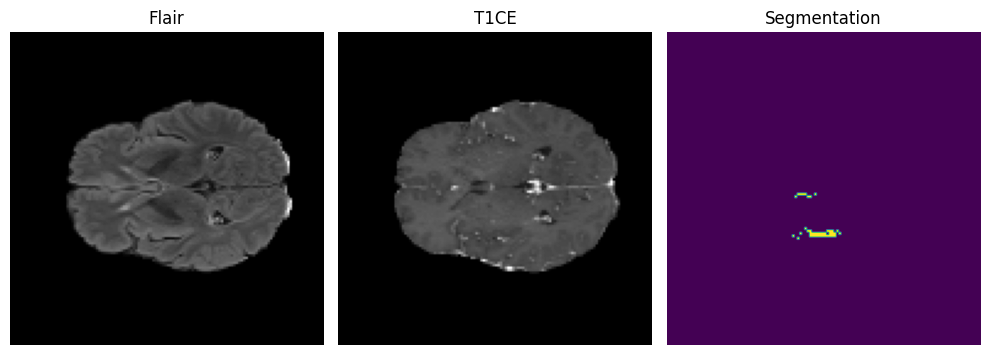

In [21]:
# Define a function to display one slice and its segmentation
def display_slice_and_segmentation(flair, t1ce, segmentation):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('Flair')
    axes[0].axis('off')

    axes[1].imshow(t1ce, cmap='gray')
    axes[1].set_title('T1CE')
    axes[1].axis('off')

    axes[2].imshow(segmentation) # Displaying segmentation
    axes[2].set_title('Segmentation')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


# Retrieve a batch from the training generator
X_batch, Y_batch = training_generator[9] #With batch_size=1, this is the 9th patient

# Extract Flair, T1CE, and segmentation from the batch
flair_batch = X_batch[:, :, :, 0]
t1ce_batch = X_batch[:, :, :, 1]
segmentation_batch = np.argmax(Y_batch, axis=-1)  # Convert one-hot encoded to categorical

# Extract a slice from Flair, T1CE, and segmentation
slice_index = 50  # Indexing starts from 0
slice_flair = flair_batch[slice_index]
slice_t1ce = t1ce_batch[slice_index]
slice_segmentation = segmentation_batch[slice_index]

# Display the 50th slice and its segmentation
display_slice_and_segmentation(slice_flair, slice_t1ce, slice_segmentation)

# Metrics and Loss

In [22]:
def calculate_class_weights(train_generator):
    """
    Calculate class weights based on training data distribution
    """
    # Count pixels per class
    class_counts = np.zeros(4)  # background, necrotic, edema, enhancing
    
    for i in range(len(train_generator)):
        _, y_batch = train_generator[i]
        for class_idx in range(4):
            class_counts[class_idx] += np.sum(y_batch[:, :, :, class_idx])
    
    # Calculate weights (inverse of frequency)
    total_pixels = np.sum(class_counts)
    class_weights = total_pixels / (4.0 * class_counts)
    
    # Normalize weights
    class_weights = class_weights / np.sum(class_weights)
    
    return class_weights

# Calculate class weights from your training data
class_weights = calculate_class_weights(training_generator)
print(f"Class weights: {class_weights}")

Class weights: [0.00153199 0.39570505 0.15292215 0.44984082]


In [23]:
def weighted_categorical_crossentropy(class_weights):
    """
    Custom loss function with class weighting
    class_weights: list of weights for each class [background, necrotic, edema, enhancing]
    """
    def loss(y_true, y_pred):
        # Scale predictions so that the class probabilities of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        
        # Clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        
        # Calculate loss with class weights
        loss = y_true * K.log(y_pred) * class_weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [24]:
# Mean IoU for tumor classes only
def mean_iou_tumor(y_true, y_pred):
    y_true_tumor = y_true[:, :, :, 1:]
    y_pred_tumor = y_pred[:, :, :, 1:]
    
    intersection = K.sum(K.round(K.clip(y_true_tumor * y_pred_tumor, 0, 1)))
    union = K.sum(K.round(K.clip(y_true_tumor + y_pred_tumor, 0, 1))) - intersection
    iou = intersection / (union + K.epsilon())
    return iou


In [25]:
# Define per class evaluation of dice coef
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon) 

In [26]:
def mean_dice_tumor(y_true, y_pred):
    dice_nec = dice_coef_necrotic(y_true, y_pred)
    dice_ed = dice_coef_edema(y_true, y_pred)
    dice_enh = dice_coef_enhancing(y_true, y_pred)
    return (dice_nec + dice_ed + dice_enh) / 3.0

# Define the Model

In [27]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

In [28]:
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))
model = build_unet(input_layer, 'he_normal', 0.2)

# Compile with weighted loss and tumor-focused metrics
model.compile(
    loss=weighted_categorical_crossentropy(class_weights),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        mean_dice_tumor
    ]
)

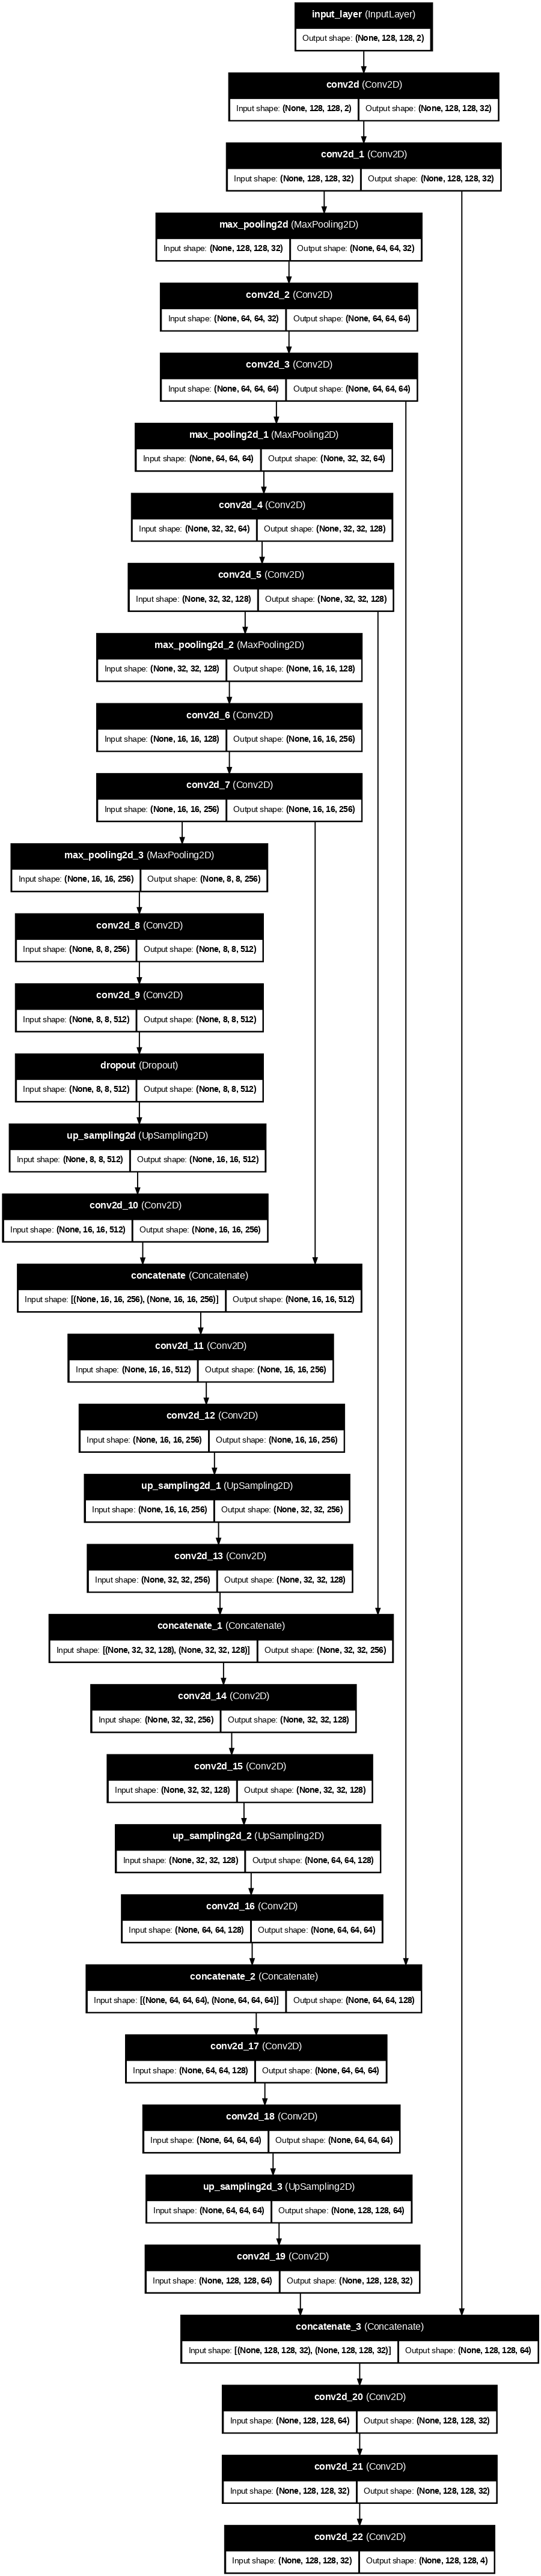

In [32]:
plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

In [29]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_mean_dice_tumor',  # Monitor tumor dice instead of loss
        factor=0.2,
        patience=2, 
        min_lr=0.000001, 
        verbose=1,
        mode='max'  # We want to maximize dice
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='model_{epoch:02d}-{val_mean_dice_tumor:.6f}.weights.h5', 
        monitor='val_mean_dice_tumor',
        verbose=1, 
        save_best_only=True, 
        save_weights_only=True,
        mode='max'
    ),
    CSVLogger('training_tumor_focused.log', separator=',', append=False)
]

In [30]:
K.clear_session()

# Train the model
history = model.fit(
    training_generator,
    epochs=35,
    steps_per_epoch=len(train_ids),
    callbacks=callbacks,
    validation_data=valid_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35


I0000 00:00:1756988284.973660     106 service.cc:148] XLA service 0x7eeb98002150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756988284.974573     106 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756988286.089186     106 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756988312.694385     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.6622 - loss: 0.0074 - mean_dice_tumor: 0.0776
Epoch 1: val_mean_dice_tumor improved from -inf to 0.12757, saving model to model_01-0.127570.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 160s 490ms/step - accuracy: 0.6625 - loss: 0.0074 - mean_dice_tumor: 0.0777 - val_accuracy: 0.7941 - val_loss: 0.0048 - val_mean_dice_tumor: 0.1276 - learning_rate: 0.0010
Epoch 2/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.7931 - loss: 0.0057 - mean_dice_tumor: 0.1403
Epoch 2: val_mean_dice_tumor did not improve from 0.12757
250/250 ━━━━━━━━━━━━━━━━━━━━ 92s 369ms/step - accuracy: 0.7931 - loss: 0.0057 - mean_dice_tumor: 0.1403 - val_accuracy: 0.7913 - val_loss: 0.0048 - val_mean_dice_tumor: 0.1273 - learning_rate: 0.0010
Epoch 3/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.7921 - loss: 0.0054 - mean_dice_tumor: 0.1417
Epoch 3: val_mean_dice_tumor improved from 0.12757 to 0.15611, saving model to model_03-0.156109.weights.

In [31]:
model.save("my_model.keras")

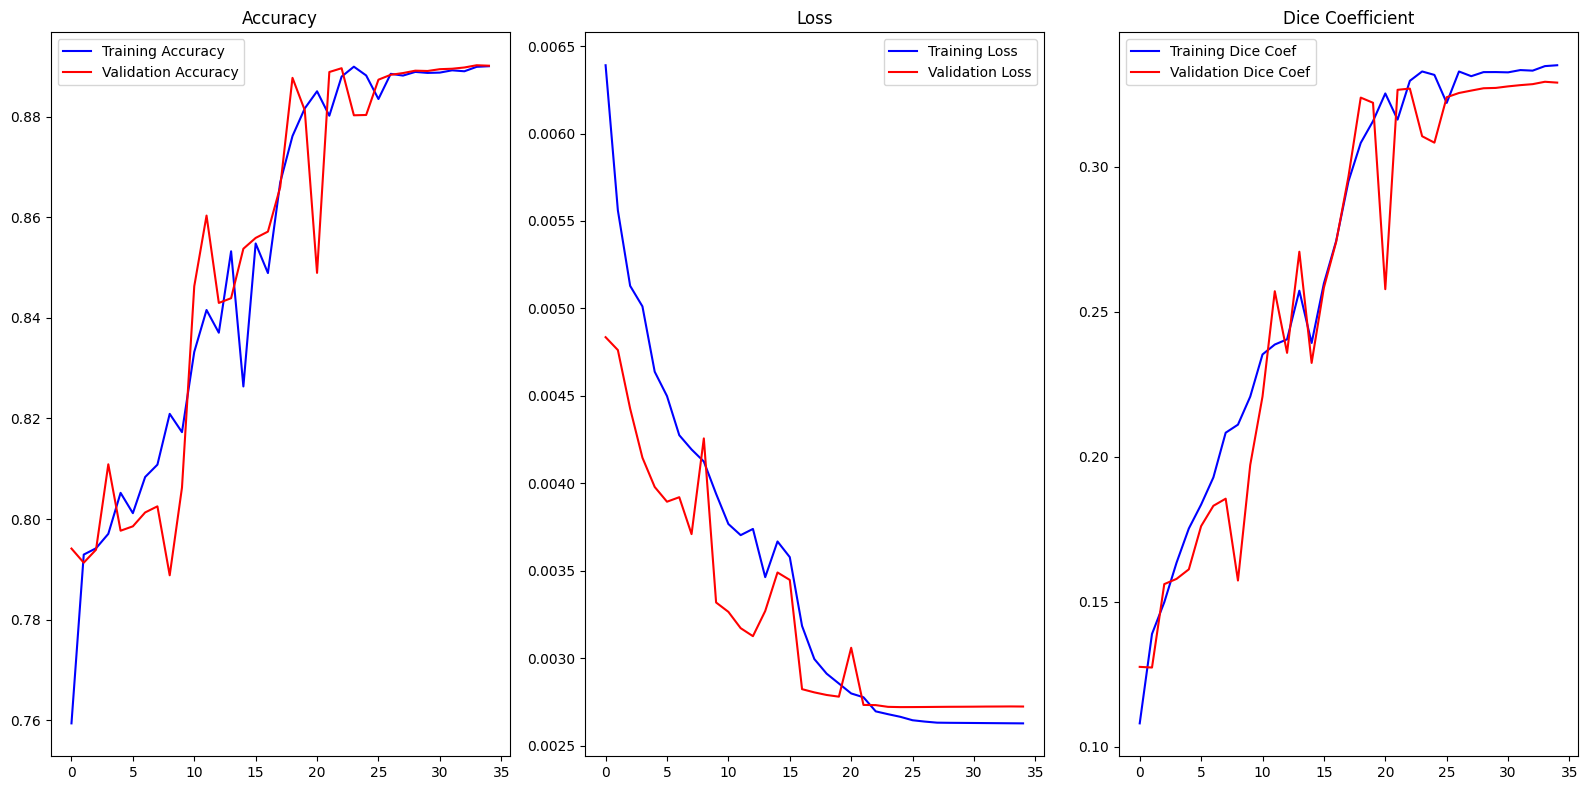

In [35]:
#history = pd.read_csv('/Users/chiaracangelosi/Documents/1-Uni/DataScience/Dataset/data/Progetto Data/training.log', sep=',', engine='python')
#history = pd.read_csv('C:/Users/g2not/Desktop/Università/Data Mining and Machine Learning/Progetto/training.log', sep=',', engine='python')
history = pd.read_csv('/kaggle/working/training_tumor_focused.log', sep=',', engine='python')

acc = history['accuracy']
val_acc = history['val_accuracy']

epoch = range(len(acc))

loss = history['loss']
val_loss = history['val_loss']

train_dice = history['mean_dice_tumor']
val_dice = history['val_mean_dice_tumor']

f, ax = plt.subplots(1, 3, figsize=(16, 8))

ax[0].plot(epoch, acc, 'b', label='Training Accuracy')
ax[0].plot(epoch, val_acc, 'r', label='Validation Accuracy')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(epoch, loss, 'b', label='Training Loss')
ax[1].plot(epoch, val_loss, 'r', label='Validation Loss')
ax[1].legend()
ax[1].set_title('Loss')

ax[2].plot(epoch, train_dice, 'b', label='Training Dice Coef')
ax[2].plot(epoch, val_dice, 'r', label='Validation Dice Coef')
ax[2].legend()
ax[2].set_title('Dice Coefficient')

plt.tight_layout()
plt.show()

In [38]:
model = keras.models.load_model('/kaggle/working/my_model.keras',
                                   custom_objects={"dice_coef" : mean_dice_tumor},
                                compile=False)

In [40]:
# Evaluate the model on the test data
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy', mean_dice_tumor])

results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)

descriptions = ["Loss", "Accuracy","Dice coefficient"]

# Combine results list and descriptions list
results_list = zip(results, descriptions)

45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 256ms/step - accuracy: 0.8871 - loss: 0.2889 - mean_dice_tumor: 0.3604

Model evaluation on the test set:
Loss : 0.3011
Accuracy : 0.88
Dice coefficient : 0.339


,Metric,Value
0,Loss,0.3011
1,Accuracy,0.8800
2,Dice coefficient,0.3390


In [41]:
# Tabella riassuntiva metriche
eval_df = pd.DataFrame({
    "Metric": descriptions[:len(results)],
    "Value": [round(v, 4) for v in results[:len(results)]]
})
display(eval_df)

,Metric,Value
0,Loss,0.3011
1,Accuracy,0.8800
2,Dice coefficient,0.3390


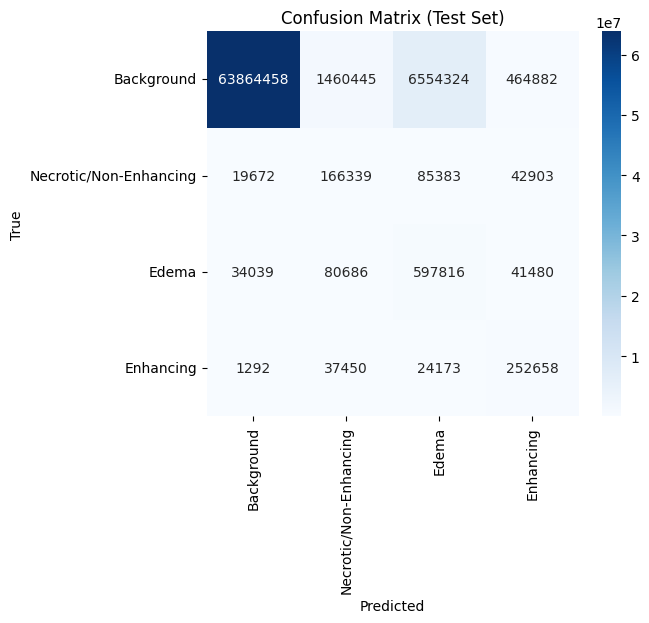

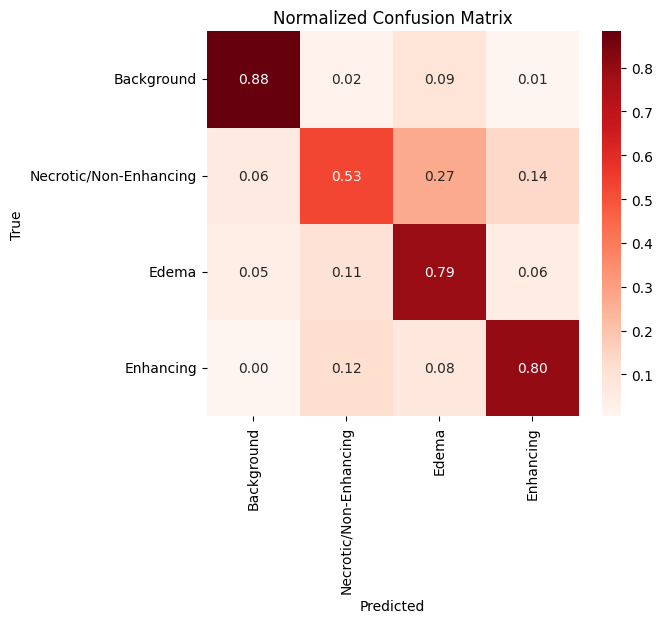

In [44]:
y_true, y_pred = [], []
for i in range(len(test_generator)):
    X_batch, y_batch = test_generator[i]
    preds = model.predict(X_batch, verbose=0)
    preds = np.argmax(preds, axis=-1).flatten()
    true = np.argmax(y_batch, axis=-1).flatten()
    y_pred.extend(preds)
    y_true.extend(true)

cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])

# Confusion matrix normalizzata (percentuali per classe)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Reds",
            xticklabels=["Background","Necrotic/Non-Enhancing","Edema","Enhancing"],
            yticklabels=["Background","Necrotic/Non-Enhancing","Edema","Enhancing"])
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()